# Prompt2Song – Text Emotion Encoder

Train an emotion-aware text encoder that powers both prompt understanding and lyric embeddings. This notebook ingests the six-class emotion dataset, fine-tunes a lightweight transformer, and exports reusable helpers for downstream stages.

## Goals
- Inspect the prompt emotion dataset and build consistent label mappings
- Fine-tune a DistilBERT-sized encoder on the six emotion classes
- Export utility functions for prompt/lyric embeddings and persist artifacts for later notebooks

> ⚙️ **Offline-friendly setup**  
Ensure the base model weights (e.g. `distilbert-base-uncased`) are cached locally before running. Set `HF_HOME` or `TRANSFORMERS_CACHE` if you maintain an offline cache.

In [1]:
import os
import json
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset

try:
    from transformers import (
        AutoConfig,
        AutoTokenizer,
        AutoModelForSequenceClassification,
        Trainer,
        TrainingArguments,
        EarlyStoppingCallback,
    )
except ImportError as exc:
    raise ImportError("Install transformers before running this notebook.") from exc

try:
    from sklearn.metrics import accuracy_score, f1_score, classification_report
except ImportError as exc:
    raise ImportError("Install scikit-learn before running this notebook.") from exc


/opt/homebrew/anaconda3/envs/4AL3py12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here we resolve project directories, ensure artifact folders exist, and define constants such as the dataset roots, model name, and random seed.

In [2]:
NOTEBOOK_DIR = Path.cwd().resolve()
if (NOTEBOOK_DIR / "datasets").exists():
    PROJECT_ROOT = NOTEBOOK_DIR
else:
    PROJECT_ROOT = NOTEBOOK_DIR.parent

DATASET_ROOT = PROJECT_ROOT / "datasets" / "emotions_NLP"
ARTIFACT_ROOT = PROJECT_ROOT / "artifacts" / "text_encoder"
ARTIFACT_ROOT.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "distilbert-base-uncased"
SEED = 13

print(f"Project root: {PROJECT_ROOT}")
print(f"Saving artifacts to: {ARTIFACT_ROOT}")


Project root: /Users/himanshu/Documents/Github/prompt2song
Saving artifacts to: /Users/himanshu/Documents/Github/prompt2song/artifacts/text_encoder


Utility helper that seeds NumPy and PyTorch for reproducibility, then applies it using the configured seed.

In [3]:
def set_seed(seed: int = 13) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(SEED)


Loads the train/val/test splits from disk, cleans whitespace, filters empty rows, and prints a small preview plus dataset sizes.

In [4]:
def load_split(split: str) -> pd.DataFrame:
    path = DATASET_ROOT / f"{split}.txt"
    if not path.exists():
        raise FileNotFoundError(path)
    df = pd.read_csv(path, sep=";", names=["text", "label"], encoding="utf-8")
    df["text"] = df["text"].astype(str).str.strip()
    df["label"] = df["label"].astype(str).str.strip()
    df = df[df["text"].str.len() > 0].reset_index(drop=True)
    return df

train_df = load_split("train")
val_df = load_split("val")
test_df = load_split("test")

print(train_df.head())
print({split: len(df) for split, df in {"train": train_df, "val": val_df, "test": test_df}.items()})


                                                text    label
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger
{'train': 16000, 'val': 2000, 'test': 2000}


Builds label↔id lookup tables, attaches numeric labels to each split, and reports label distribution for sanity checking.

In [5]:
labels = sorted(train_df["label"].unique())
labels_val = sorted(val_df["label"].unique())
labels_test = sorted(test_df["label"].unique())
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for label, idx in label2id.items()}

label2id_val = {label: idx for idx, label in enumerate(labels_val)}
id2label_val = {idx: label for label, idx in label2id_val.items()}

label2id_test = {label: idx for idx, label in enumerate(labels_test)}
id2label_test = {idx: label for label, idx in label2id_test.items()}

for df in (train_df, val_df, test_df):
    df["label_id"] = df["label"].map(label2id)

print("Label mapping:", label2id)
print("Train distribution:", train_df["label"].value_counts())
print("Val distribution:", val_df["label"].value_counts())
print("Test distribution:", test_df["label"].value_counts())


Label mapping: {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}
Train distribution: label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64
Val distribution: label
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64
Test distribution: label
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64


Initializes the tokenizer and defines an EmotionDataset wrapper that tokenizes text samples on the fly before instantiating dataset objects for each split.

In [6]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class EmotionDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, tokenizer, max_length: int = 128):
        self.dataframe = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        encoded = self.tokenizer(
            row["text"],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        item = {key: val.squeeze(0) for key, val in encoded.items()}
        item["labels"] = torch.tensor(row["label_id"], dtype=torch.long)
        return item

train_dataset = EmotionDataset(train_df, tokenizer)
val_dataset = EmotionDataset(val_df, tokenizer)
test_dataset = EmotionDataset(test_df, tokenizer)


Creates a classification configuration for DistilBERT and loads the base model with the updated label metadata.

In [7]:
config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Defines compute_metrics so the Trainer can report accuracy and macro/weighted F1 scores during evaluation.

In [8]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    metrics = {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }
    return metrics


### Trainer configuration
Adjust `per_device_train_batch_size`, `num_train_epochs`, or `learning_rate` for your hardware budget.

Configures TrainingArguments (batch sizes, epochs, evaluation cadence, etc.) and instantiates the Hugging Face Trainer with datasets and metric function.

In [9]:
training_args = TrainingArguments(
    output_dir=str(ARTIFACT_ROOT / "checkpoints"),
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    logging_steps=50,
    report_to="none",
)
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2,
    early_stopping_threshold=0.0,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
)


Optionally kicks off fine-tuning via trainer.train() and evaluates the pre-trained checkpoint to provide baseline metrics.

In [10]:
# Uncomment to launch full fine-tuning
trainer.train()

# Example: evaluate initial (pre-trained) checkpoint before fine-tuning
pretrain_metrics = trainer.evaluate()
print(pretrain_metrics)


/opt/homebrew/anaconda3/envs/4AL3py12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.207300,0.206053,0.930000,0.904729,0.929994
2,0.124000,0.161338,0.936000,0.909825,0.935681
3,0.062900,0.157195,0.940500,0.919941,0.940428


/opt/homebrew/anaconda3/envs/4AL3py12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/envs/4AL3py12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/envs/4AL3py12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.15719455480575562, 'eval_accuracy': 0.9405, 'eval_f1_macro': 0.9199406609815579, 'eval_f1_weighted': 0.9404275227817543, 'eval_runtime': 10.0069, 'eval_samples_per_second': 199.862, 'eval_steps_per_second': 6.296, 'epoch': 3.0}


Runs final evaluation on the test split, then saves the fine-tuned model, tokenizer, and label mapping artifacts for reuse.

In [11]:
# After calling trainer.train(), run evaluation and save artifacts
eval_metrics = trainer.evaluate(test_dataset)
print("Test metrics:", eval_metrics)

trainer.save_model(ARTIFACT_ROOT / "hf_model")
tokenizer.save_pretrained(ARTIFACT_ROOT / "hf_model")

with open(ARTIFACT_ROOT / "label2id.json", "w", encoding="utf-8") as fp:
    json.dump(label2id, fp, indent=2)


/opt/homebrew/anaconda3/envs/4AL3py12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Test metrics: {'eval_loss': 0.1684221476316452, 'eval_accuracy': 0.9275, 'eval_f1_macro': 0.8829597905891552, 'eval_f1_weighted': 0.9269128639446722, 'eval_runtime': 10.079, 'eval_samples_per_second': 198.432, 'eval_steps_per_second': 6.251, 'epoch': 3.0}


### Training diagnostics
Use the trainer log history to visualize how training and validation loss evolved across epochs.

,epoch,step,loss,eval_loss,eval_accuracy,eval_f1_macro
61,3.0,3000,0.0629,NaN,NaN,NaN
62,3.0,3000,NaN,0.157195,0.9405,0.919941
63,3.0,3000,NaN,NaN,NaN,NaN
64,3.0,3000,NaN,0.157195,0.9405,0.919941
65,3.0,3000,NaN,0.168422,0.9275,0.882960


Best model checkpoint: /Users/himanshu/Documents/Github/prompt2song/artifacts/text_encoder/checkpoints/checkpoint-3000
Best f1_macro: 0.9199
Reached at step 3000 (epoch 3.00)
Metrics at best checkpoint:


,epoch,step,loss,eval_loss,eval_accuracy,eval_f1_macro
65,3.0,3000,NaN,0.168422,0.9275,0.88296


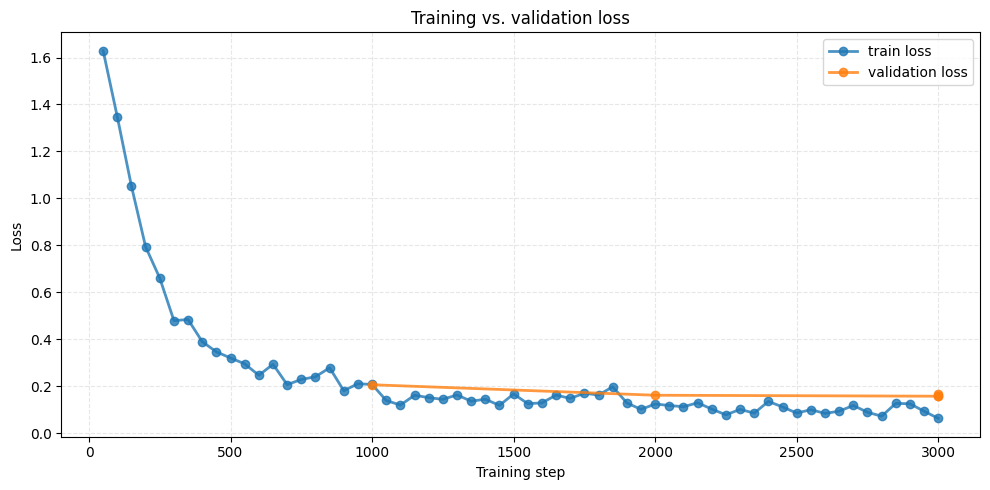

In [12]:
history = pd.DataFrame(trainer.state.log_history)
if history.empty:
    print("Trainer log history is empty; run trainer.train() first.")
else:
    train_history = history.dropna(subset=["loss"])
    eval_history = history.dropna(subset=["eval_loss"])
    fig, ax = plt.subplots(figsize=(10, 5))
    if not train_history.empty:
        ax.plot(train_history["step"], train_history["loss"], label="train loss", marker="o", linewidth=2, alpha=0.8)
    if not eval_history.empty:
        ax.plot(eval_history["step"], eval_history["eval_loss"], label="validation loss", marker="o", linewidth=2, alpha=0.8)
    ax.set_xlabel("Training step")
    ax.set_ylabel("Loss")
    ax.set_title("Training vs. validation loss")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    display_cols = [col for col in ["epoch", "step", "loss", "eval_loss", "eval_accuracy", "eval_f1_macro"] if col in history.columns]
    if display_cols:
        display(history[display_cols].dropna(how="all").tail())
    best_checkpoint = getattr(trainer.state, "best_model_checkpoint", None)
    best_metric = getattr(trainer.state, "best_metric", None) or getattr(trainer.state, "best_model_metric", None)
    best_metric_name = (getattr(trainer.args, "metric_for_best_model", None)
                        or getattr(trainer.state, "best_model_metric_name", None))
    best_step = getattr(trainer.state, "best_iteration", None)
    if best_step is None and best_checkpoint:
        step_fragment = Path(best_checkpoint).name.split("-")[-1]
        if step_fragment.isdigit():
            best_step = int(step_fragment)
    best_epoch = None
    if best_step is not None and "epoch" in history.columns:
        epoch_series = history.loc[history["step"] == best_step, "epoch"].dropna()
        if not epoch_series.empty:
            best_epoch = float(epoch_series.iloc[-1])
    print("Best model checkpoint:", best_checkpoint or "not available yet")
    if best_metric is not None:
        metric_label = best_metric_name or "metric"
        print(f"Best {metric_label}: {best_metric:.4f}")
    if best_step is not None:
        if best_epoch is not None:
            print(f"Reached at step {best_step} (epoch {best_epoch:.2f})")
        else:
            print(f"Reached at step {best_step}")
    if display_cols and best_step is not None:
        best_row = history.loc[history["step"] == best_step, display_cols].dropna(how="all")
        if not best_row.empty:
            print("Metrics at best checkpoint:")
            display(best_row.tail(1))

## Embedding helper
Use the fine-tuned checkpoint to embed both prompts and lyrics via mean pooling of token embeddings.

Implements a lightweight TextEmotionEncoder wrapper that loads the fine-tuned model and exposes a mean-pooled encode() helper.

In [13]:
class TextEmotionEncoder(torch.nn.Module):
    def __init__(self, model_dir: Path, device: str | None = None):
        super().__init__()
        from transformers import AutoModel

        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.base_model = AutoModel.from_pretrained(model_dir).to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_dir)

    @torch.no_grad()
    def encode(self, texts: List[str], batch_size: int = 32) -> np.ndarray:
        embeddings = []
        for start in range(0, len(texts), batch_size):
            batch = texts[start:start+batch_size]
            tokens = self.tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=256,
                return_tensors="pt",
            ).to(self.device)
            outputs = self.base_model(**tokens)
            token_embeddings = outputs.last_hidden_state
            attention_mask = tokens.attention_mask.unsqueeze(-1)
            summed = (token_embeddings * attention_mask).sum(dim=1)
            counts = attention_mask.sum(dim=1)
            mean_pooled = summed / counts
            embeddings.append(mean_pooled.cpu().numpy())
        return np.vstack(embeddings)


Demonstrates encoding the training prompts with the helper and persists the resulting embeddings for downstream notebooks.

In [14]:
# Example usage (requires fine-tuned weights saved above)
encoder = TextEmotionEncoder(ARTIFACT_ROOT / "hf_model")
prompt_embeddings = encoder.encode(train_df["text"].tolist())
np.save(ARTIFACT_ROOT / "train_prompt_embeddings.npy", prompt_embeddings)


#### Quick demo
Use a couple of sample prompts to verify the saved encoder produces fixed-size embeddings.

In [15]:
# Quick smoke test for the text encoder
if (ARTIFACT_ROOT / 'hf_model').exists():
    demo_encoder = TextEmotionEncoder(ARTIFACT_ROOT / 'hf_model')
    sample_prompts = [
        'I feel hopeful and excited about tomorrow',
    ]
    demo_embeddings = demo_encoder.encode(sample_prompts)
    print('Embeddings shape:', demo_embeddings.shape)
    print('Sample embeddings:', demo_embeddings[0][2])
else:
    print('⚠️ Fine-tuned weights not found; run trainer.train() and save artifacts first.')


Embeddings shape: (1, 768)
Sample embeddings: -0.5379253


### Embedding comparison visualizer
Plot the most divergent embedding dimensions for two texts to highlight how their emotion vectors differ.

Cosine similarity: 0.161
Cosine similarity: 0.941


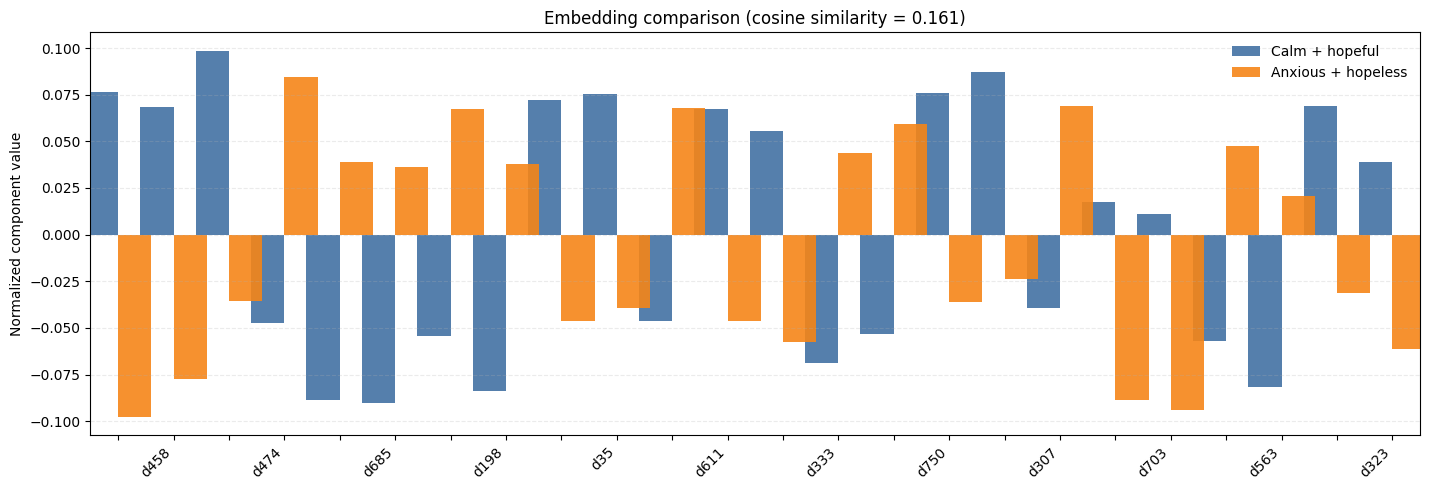

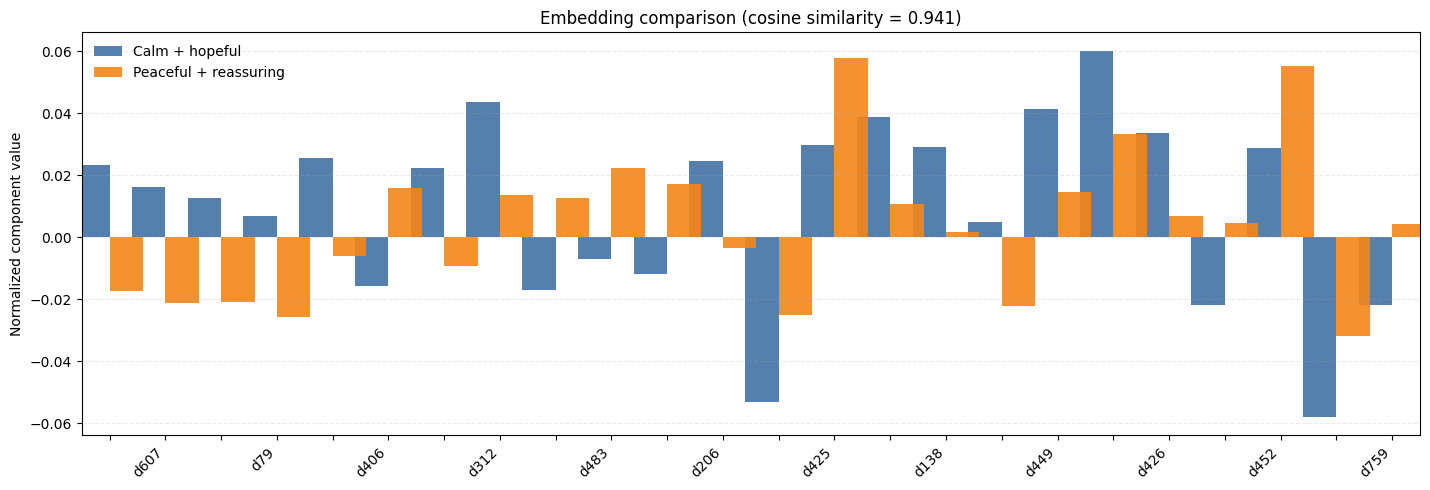

In [16]:
if 'encoder' not in globals():
    if not (ARTIFACT_ROOT / 'hf_model').exists():
        raise FileNotFoundError('Fine-tuned encoder not found; train and save the model first.')
    encoder = TextEmotionEncoder(ARTIFACT_ROOT / 'hf_model')


# def plot_embedding_comparison(text_a: str, text_b: str, labels = ("Text A", "Text B"), top_dims: int = 24) -> float:
#     '''Plot the largest-magnitude component differences between two normalized embeddings.'''
#     vectors = encoder.encode([text_a, text_b])
#     vectors = vectors / np.clip(np.linalg.norm(vectors, axis=1, keepdims=True), a_min=1e-12, a_max=None)
#     diffs = np.abs(vectors[0] - vectors[1])
#     top_dims = min(top_dims, diffs.size)
#     top_idx = np.argsort(diffs)[::-1][:top_dims]
#     dims = [f'd{idx}' for idx in top_idx]
#     x = np.arange(top_dims)
#     width = 0.42
#     fig, ax = plt.subplots(figsize=(14, 5))
#     ax.bar(x - width / 2, vectors[0, top_idx], width, label=labels[0])
#     ax.bar(x + width / 2, vectors[1, top_idx], width, label=labels[1])
#     ax.set_xticks(x)
#     ax.set_xticklabels(dims, rotation=45, ha='right')
#     ax.set_ylabel('Normalized component value')
#     cosine_sim = float(np.dot(vectors[0], vectors[1]))
#     ax.set_title(f"Embedding comparison (cosine similarity = {cosine_sim:.3f})")
#     ax.legend()
#     ax.grid(True, axis='y', linestyle='--', alpha=0.3)
#     plt.tight_layout()
#     return cosine_sim
def plot_embedding_comparison(text_a: str, text_b: str, labels = ("Text A", "Text B"), top_dims: int = 24) -> float:
    '''Plot the largest-magnitude component differences between two normalized embeddings.'''
    vectors = encoder.encode([text_a, text_b])
    vectors = vectors / np.clip(np.linalg.norm(vectors, axis=1, keepdims=True), a_min=1e-12, a_max=None)
    diffs = np.abs(vectors[0] - vectors[1])
    top_dims = min(top_dims, diffs.size)
    top_idx = np.argsort(diffs)[::-1][:top_dims]
    dims = [f'd{idx}' for idx in top_idx]

    # spacing & layout tweaks to make axis easier to read
    spacing = 1.6                       # increase spacing between bars
    x = np.arange(top_dims) * spacing
    width = 0.6 * spacing               # bar width scales with spacing
    fig_w = max(14, top_dims * 0.6)     # expand figure width for many dims
    fig, ax = plt.subplots(figsize=(fig_w, 5))

    ax.bar(x - width / 2, vectors[0, top_idx], width, label=labels[0], color="#4C78A8", alpha=0.95)
    ax.bar(x + width / 2, vectors[1, top_idx], width, label=labels[1], color="#F58518", alpha=0.9)

    ax.set_xticks(x)
    ax.set_xticklabels(dims, rotation=45, ha='right')
    ax.set_xlim(x[0] - spacing * 0.5, x[-1] + spacing * 0.5)  # small margin at ends

    # reduce label clutter for large top_dims by hiding every other tick label
    if top_dims > 12:
        for lbl in ax.xaxis.get_ticklabels()[::2]:
            lbl.set_visible(False)

    ax.set_ylabel('Normalized component value')
    cosine_sim = float(np.dot(vectors[0], vectors[1]))
    ax.set_title(f"Embedding comparison (cosine similarity = {cosine_sim:.3f})")
    ax.legend(frameon=False)
    ax.grid(True, axis='y', linestyle='--', alpha=0.25)
    plt.tight_layout()
    return cosine_sim

sample_text_a = "I feel calm, supported, and ready to keep going."
sample_text_b = "Everything feels chaotic and I'm running out of hope."
comparison_cos = plot_embedding_comparison(sample_text_a, sample_text_b, labels=("Calm + hopeful", "Anxious + hopeless"))
print(f"Cosine similarity: {comparison_cos:.3f}")

sample_text_a = "I feel calm, supported, and ready to keep going."
sample_text_b = "This is so peaceful and reassuring, I feel at ease."
comparison_cos = plot_embedding_comparison(sample_text_a, sample_text_b, labels=("Calm + hopeful", "Peaceful + reassuring"))
print(f"Cosine similarity: {comparison_cos:.3f}")


## Build merged Spotify lyrics dataset
Combine `songs.csv` and `spotify_songs.csv`, normalize key columns, and persist a cleaned dataset we can reuse for model training or lyric retrieval.

In [17]:
import ast
import re
from IPython.display import display

SONGS_META_PATH = PROJECT_ROOT / "datasets" / "song_features" / "songs.csv"
SPOTIFY_SONGS_PATH = PROJECT_ROOT / "datasets" / "song_features" / "spotify_songs.csv"
COMBINED_SONGS_PATH = PROJECT_ROOT / "datasets" / "song_features" / "merged_spotify_songs.csv"

CANONICAL_COLUMNS = [
    "song_id",
    "name",
    "artists",
    "album_name",
    "album_release_date",
    "playlist_genre",
    "playlist_subgenre",
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
    "track_popularity",
    "lyrics",
    "language",
    "source",
]

def _parse_lyrics(raw: str) -> str:
    if pd.isna(raw):
        return ""
    text = str(raw).strip()
    if not text:
        return ""
    if text.startswith("[") and text.endswith("]"):
        try:
            tokens = ast.literal_eval(text)
            if isinstance(tokens, (list, tuple)):
                text = " ".join(str(tok) for tok in tokens)
        except Exception:
            text = text.replace("[", " ").replace("]", " ")
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def _clean_artists(value: str) -> str:
    if pd.isna(value):
        return ""
    value = str(value)
    value = value.replace("[", "").replace("]", "")
    value = value.replace("'", "")
    value = re.sub(r"\s+", " ", value)
    return value.strip()

def _standardize_song_frame(df: pd.DataFrame, source: str) -> pd.DataFrame:
    rename_map = {
        "track_id": "song_id",
        "track_name": "name",
        "track_artist": "artists",
        "track_album_name": "album_name",
        "track_album_release_date": "album_release_date",
        "playlist_subgenre": "playlist_subgenre",
        "language": "language",
    }
    df = df.rename(columns=rename_map)
    keep_cols = [col for col in CANONICAL_COLUMNS if col in df.columns]
    missing_cols = [col for col in CANONICAL_COLUMNS if col not in df.columns]
    for col in missing_cols:
        df[col] = np.nan
    df = df[CANONICAL_COLUMNS].copy()
    df["source"] = source
    df["lyrics"] = df["lyrics"].apply(_parse_lyrics)
    df = df[df["lyrics"].str.len() >= 30]
    df["artists"] = df["artists"].apply(_clean_artists)
    df["album_name"] = df["album_name"].fillna("")
    df["language"] = df["language"].fillna("unknown")
    numeric_cols = [
        "danceability",
        "energy",
        "key",
        "loudness",
        "mode",
        "speechiness",
        "acousticness",
        "instrumentalness",
        "liveness",
        "valence",
        "tempo",
        "duration_ms",
        "track_popularity",
    ]
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=["song_id", "lyrics"])
    df["lyrics"] = df["lyrics"].str.lower()
    df["lyrics"] = df["lyrics"].str.replace(r"\s+", " ", regex=True).str.strip()
    df["lyrics_length"] = df["lyrics"].str.len()
    return df

songs_base = pd.read_csv(SONGS_META_PATH)
spotify_additional = pd.read_csv(SPOTIFY_SONGS_PATH)

songs_base = _standardize_song_frame(songs_base, source="songs_csv")
spotify_additional = _standardize_song_frame(spotify_additional, source="spotify_songs_csv")

merged_songs = pd.concat([songs_base, spotify_additional], ignore_index=True)
merged_songs = merged_songs.drop_duplicates(subset=["song_id"])
merged_songs = merged_songs.reset_index(drop=True)

print(f"Merged songs: {len(merged_songs):,} rows")
display(merged_songs.sample(3))

Merged songs: 18,247 rows


,song_id,name,artists,album_name,album_release_date,playlist_genre,playlist_subgenre,danceability,energy,key,...,instrumentalness,liveness,valence,tempo,duration_ms,track_popularity,lyrics,language,source,lyrics_length
217,4cZ3UsiKd1kUQIaq4BFIj2,no one compares to you,Jack&jack,,2019-01-25,Pop,NaN,0.64183,0.742462,0.090909,...,NaN,0.078705,0.635036,0.346527,182920,0.136364,thoughts of you and me keep passing by like sh...,unknown,songs_csv,2969
5589,25YvGDl2zSE0pH8jrMZ6aY,Therapy,Khalid,American Teen,2017-04-27,r&b,urban contemporary,0.70700,0.484000,9.000000,...,0.00344,0.256000,0.430000,92.988000,257960,65.000000,something that you're doing has me falling all...,en,spotify_songs_csv,1642
14580,6aDYL0klsShJ1NDScruk2G,Stars,Callalily,Destination XYZ,2006-07-17,rock,classic rock,0.50100,0.555000,7.000000,...,0.00003,0.085900,0.436000,126.207000,233307,60.000000,a picture of you reminds me how the years have...,en,spotify_songs_csv,1214


Persist the cleaned corpus for downstream training/reranking.

In [18]:
merged_songs.to_csv(COMBINED_SONGS_PATH, index=False)
print(f"Saved merged dataset to {COMBINED_SONGS_PATH}")
merged_songs.head(2)

Saved merged dataset to /Users/himanshu/Documents/Github/prompt2song/datasets/song_features/merged_spotify_songs.csv


,song_id,name,artists,album_name,album_release_date,playlist_genre,playlist_subgenre,danceability,energy,key,...,instrumentalness,liveness,valence,tempo,duration_ms,track_popularity,lyrics,language,source,lyrics_length
0,6oJ6le65B3SEqPwMRNXWjY,higher love,Kygo,,2019-06-28,Pop,NaN,0.632680,0.667346,0.727273,...,NaN,0.086004,0.391370,0.290605,228267,0.500000,"bring me higher love, love bring me higher lov...",unknown,songs_csv,1683
1,3yNZ5r3LKfdmjoS3gkhUCT,bad guy (with justin bieber),Billieeilish,,2019-07-11,Pop,NaN,0.602614,0.425904,0.000000,...,NaN,0.102930,0.687634,0.508374,194840,0.318182,"yeah, yeah oh, ah white shirt now red, my bloo...",unknown,songs_csv,5531


## Lyrics emotion tagging & retrieval setup
Sample ~1k songs with lyrics, clean the text, and prep artifacts so prompts and lyrics share the same embedding space for quick experiments.

In [19]:
LYRICS_SAMPLE_SIZE = 1000
SONG_DATA_PATH = PROJECT_ROOT / "datasets" / "song_features" / "merged_spotify_songs.csv"
LYRICS_ARTIFACT_DIR = ARTIFACT_ROOT / "lyrics_retrieval"
LYRICS_ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

def load_lyrics_sample(csv_path: Path, sample_size: int = 1000, chunk_size: int = 5000) -> pd.DataFrame:
    if not csv_path.exists():
        raise FileNotFoundError(csv_path)

    rng = np.random.default_rng(SEED)
    reservoir: List[dict] = []
    total_rows = 0
    usecols = ["song_id", "name", "album_name", "artists", "lyrics"]

    for chunk in pd.read_csv(csv_path, usecols=usecols, chunksize=chunk_size):
        chunk = chunk.dropna(subset=["lyrics"])
        chunk["lyrics"] = (
            chunk["lyrics"]
            .astype(str)
            .str.replace(r"\s+", " ", regex=True)
            .str.strip()
        )
        chunk = chunk[chunk["lyrics"].str.len() >= 30]
        if chunk.empty:
            continue

        for row in chunk.itertuples(index=False):
            total_rows += 1
            row_dict = row._asdict()
            if len(reservoir) < sample_size:
                reservoir.append(row_dict)
            else:
                j = rng.integers(0, total_rows)
                if j < sample_size:
                    reservoir[j] = row_dict

    if not reservoir:
        raise ValueError("No lyric rows sampled; check the dataset path.")

    sampled = pd.DataFrame(reservoir).reset_index(drop=True)
    sampled["lyrics_length"] = sampled["lyrics"].str.len()
    print(f"Collected {len(sampled)} songs from {total_rows} lyric rows.")
    return sampled

lyrics_df = load_lyrics_sample(SONG_DATA_PATH, sample_size=LYRICS_SAMPLE_SIZE)
lyrics_df.head()

Collected 1000 songs from 18247 lyric rows.


,song_id,name,artists,album_name,lyrics,lyrics_length
0,6KQxGfOdjHMh5wT15t0gJj,All Into Nothing,R3HAB,All Into Nothing,haven't seen you since the summer strangers ta...,917
1,4e9eGQYsOiBcftrWXwsVco,Aerials,System Of A Down,Toxicity,life is a waterfall we're one in the river and...,1078
2,2TQaMcc3BEAF5Srn7FCipl,Always,Atlantic Starr,All In The Name Of Love,"girl, you are to me all that a woman should be...",693
3,0FigU3fBZd8gtBYR3XUx5e,Fade All My Life,Unlike Pluto,Fade All My Life,i don't wanna know how how to read my own mess...,1046
4,6oGPZcErzd9Hjw3E4sDBrq,If It Isn't Love,New Edition,Greatest Hits-Volume One,i don't love her i tried to tell myself but yo...,1955


Predict an emotion label for each lyric with the fine-tuned classifier, embed the lyrics with the shared encoder, and persist lightweight artifacts for retrieval.

In [20]:
if not (ARTIFACT_ROOT / "hf_model").exists():
    raise FileNotFoundError(
        "Missing fine-tuned checkpoint at artifacts/text_encoder/hf_model. Run trainer.train() and rerun the save cell first."
    )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emotion_classifier = AutoModelForSequenceClassification.from_pretrained(
    ARTIFACT_ROOT / "hf_model"
).to(device)
emotion_classifier.eval()

lyrics_encoder = TextEmotionEncoder(ARTIFACT_ROOT / "hf_model", device=device)

@torch.no_grad()
def predict_emotions(texts: List[str], batch_size: int = 32) -> List[str]:
    labels = []
    for start in range(0, len(texts), batch_size):
        batch = texts[start : start + batch_size]
        encodings = lyrics_encoder.tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt",
        ).to(device)
        logits = emotion_classifier(**encodings).logits
        labels.extend(logits.argmax(dim=-1).cpu().tolist())
    return [id2label[idx] for idx in labels]

lyrics_df["emotion_label"] = predict_emotions(lyrics_df["lyrics"].tolist())

lyrics_embeddings = lyrics_encoder.encode(lyrics_df["lyrics"].tolist(), batch_size=32)
lyric_unit_embeddings = lyrics_embeddings / np.clip(
    np.linalg.norm(lyrics_embeddings, axis=1, keepdims=True),
    a_min=1e-12,
    a_max=None,
)

np.save(LYRICS_ARTIFACT_DIR / "lyrics_embeddings.npy", lyrics_embeddings)

metadata_cols = [
    "song_id",
    "name",
    "album_name",
    "artists",
    "emotion_label",
    "lyrics",
    "lyrics_length",
]
lyrics_metadata_path = LYRICS_ARTIFACT_DIR / "lyrics_metadata.jsonl"
lyrics_df[metadata_cols].to_json(
    lyrics_metadata_path,
    orient="records",
    lines=True,
    force_ascii=False,
)

print(f"Saved lyric embeddings to {LYRICS_ARTIFACT_DIR / 'lyrics_embeddings.npy'}")
print(f"Saved lyric metadata to {lyrics_metadata_path}")

Saved lyric embeddings to /Users/himanshu/Documents/Github/prompt2song/artifacts/text_encoder/lyrics_retrieval/lyrics_embeddings.npy
Saved lyric metadata to /Users/himanshu/Documents/Github/prompt2song/artifacts/text_encoder/lyrics_retrieval/lyrics_metadata.jsonl


Retrieve the top-N songs whose lyric embeddings are closest to a prompt embedding (cosine similarity in the shared space).

In [21]:
def retrieve_songs(prompt: str, top_k: int = 5) -> pd.DataFrame:
    if lyrics_df.empty:
        raise ValueError("lyrics_df is empty. Run the sampling cell first.")

    prompt_vec = lyrics_encoder.encode([prompt])[0]
    prompt_vec = prompt_vec / max(np.linalg.norm(prompt_vec), 1e-12)
    scores = lyric_unit_embeddings @ prompt_vec
    top_idx = np.argsort(scores)[::-1][:top_k]
    results = lyrics_df.iloc[top_idx].copy()
    results["similarity"] = scores[top_idx]
    return results[["name", "artists", "album_name", "emotion_label", "similarity", "lyrics"]]

demo_prompt = "I just spilt water on my notes and ruined all my hardwork"
top_matches = retrieve_songs(demo_prompt, top_k=3)

for rank, row in enumerate(top_matches.itertuples(index=False), start=1):
    print(f"{rank}. {row.name} — {row.artists} | {row.emotion_label} | score={row.similarity:.3f}")
    print(row.lyrics[:200].replace("\n", " ") + "...")
    print("-" * 80)

1. Needed Me — Rihanna | sadness | score=0.941
mustard on the beat, ho! i was good on my own, that's the way it was that's the way it was you was good on the low for a faded fuck on some faded love shit, what the fuck you complaining for? feeling ...
--------------------------------------------------------------------------------
2. The Truth — Sevendust | sadness | score=0.939
no more time for saving what the hell did you give? what the hell did you do? just more numb to waste it you will mean nothing you will be nothing one more tragic instant lost right underneath while y...
--------------------------------------------------------------------------------
3. Wasted On You — Louis Futon | sadness | score=0.934
do you only love me when you're high? will you still want me when you're not? i've got this poison running deep in my mind, my mind cause i think that i'm the only one but maybe you just know what i w...
---------------------------------------------------------------------------